In [131]:
import sys
import os
import numpy as np
import similaritymeasures
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from textwrap import wrap
import json
import pickle
from zipfile import ZipFile
from math import ceil
from scipy import stats
import re
import markovify as mk

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Map_Processing")
    sys.path.append(module_path+"\\Note_Timing")
    sys.path.append(module_path+"\\Baseline_Model")

import importlib
importlib.reload(sys.modules['Markov_Chain_model'])

from Markov_Chain_model import get_map_from_song

In [4]:
# Get maps dataframe back from the pickle file
maps_df = pd.read_pickle("../Data_Gather_Filter_Download/downloaded_maps_df.pkl")

In [5]:
with open('../Baseline_Model/markov_model_7_state.json', 'r') as markov_file:
    markov_chain_str = json.load(markov_file)
    markov_chain = mk.Chain.from_json(markov_chain_str)

In [172]:
def count_notes(notes, song_length, bpm):
    counts = [0] * ceil(song_length / 10)
    timings_seen = []
    for note in notes:
        note_time = (note['_time'] / bpm) * 60
        if note_time in timings_seen:
            continue
        timings_seen.append(note_time)
        note_bucket = int(note_time / 10)
        if note_time > song_length:
            # print("Note is after song. Time {}, Song length {}, Bucket {}, Num buckets {}".format(note_time, song_length, note_bucket, len(counts)))
            return counts
        counts[note_bucket] += 1
    return counts

In [175]:
def compare_markov_model(maps_df, max_comparisons=100, plot=False):
    average_r = 0
    num_comparisons = 0
    for file_path in maps_df.file_path.unique():
        if num_comparisons > max_comparisons:
            break
        if file_path != "NOT_FOUND":
            with ZipFile("../Data_Gather_Filter_Download/{}".format(file_path)) as folder:
                folder_name = file_path.rsplit('/', 1)[-1]
                folder_name = folder_name.split('.')[0]
                song_length = (maps_df.loc[maps_df['file_path'] == file_path])['length'].values[0]
                bpm = (maps_df.loc[maps_df['file_path'] == file_path])['bpm'].values[0]
                song_name = (maps_df.loc[maps_df['file_path'] == file_path])['song_name'].values[0]
                folder.extractall(path="./Comparisons/{}".format(folder_name))
                filenames = folder.namelist()
                difficulties_dats = [diff for diff in filenames if diff in ["Expert.dat", "ExpertPlus.dat"]]
                human_counts = []
                dat_json = {}
                for difficulties_dat in difficulties_dats:
                    with folder.open(difficulties_dat) as diff_dat:
                        dat_json = json.load(diff_dat)
                        human_counts.append(count_notes(dat_json['_notes'], song_length, bpm))

                song_file = list(filter(lambda x: re.match(r'(^.+\.(egg|ogg|mp4|mp3))', x, flags=re.I), filenames))[0]
                get_map_from_song('./Comparisons/{}/{}'.format(folder_name, song_file), markov_chain, 
                                  model_path='../Baseline_Model/markov_model_7_state.json',  
                                  output_file_path='Generated_{}.dat'.format(folder_name), start_time=1, bpm=bpm
                )
                generated_count = []
                with open('Generated_{}.dat'.format(folder_name), 'r') as gen_map:
                    gen_json = json.load(gen_map)
                    generated_count = count_notes(gen_json['_notes'], song_length, bpm)
                    # print("Gen count:{}".format(generated_count))
                os.remove('Generated_{}.dat'.format(folder_name))
                
                # print("Num counts {}".format(len(human_counts)))
                for human_count in human_counts:
                    # print("Human count:{}".format(human_count))

                    pearson_r, _ = stats.pearsonr(human_count, generated_count)
                    pearson_r = abs(pearson_r)
                    print("Pearson_r {}".format(pearson_r))
                    average_r += pearson_r
                    

                    spearman_r, _ = stats.spearmanr(human_count, generated_count)
                    print("Spearman_r {}".format(spearman_r))

                    xvals = [5 + 10*i for i in range(len(human_count))]

                    # Turn into shape that similarity understands
                    gen_data = np.zeros((len(human_count), 2))
                    gen_data[:, 0] = xvals
                    gen_data[:, 1] = generated_count

                    human_data = np.zeros((len(human_count), 2))
                    human_data[:, 0] = xvals
                    human_data[:, 1] = human_count

                    curve_len = similaritymeasures.curve_length_measure(human_data, gen_data)
                    fretchet = similaritymeasures.frechet_dist(human_data, gen_data)
                    print("Curve length measure: {}".format(curve_len))
                    print("Fretchet measure: {}".format(fretchet))
                    dtw, _ = similaritymeasures.dtw(human_data, gen_data)
                    print("Dynamic time warping measure: {}".format(dtw))
                    
                    if plot:
                        # Plot the graphs
                        title = "Number of notes in 10 second intervals on the song:\n{}".format(song_name)       
                        # plt.subplots_adjust(top=0.85)
                        # plt.title('\n'.join(wrap(title, 60)), y = 1.04)
                        plt.title(title)
                        fontP = FontProperties()
                        fontP.set_size('small')
                        
                        p1, = plt.plot(xvals, human_count, label="Human-made Map")
                        p2, = plt.plot(xvals, generated_count, label="Markov Model Map")
                        plt.xlabel("Song Duration")
                        plt.ylabel("Number of Notes")
 
                        # Stupid workaround cause python is dum
                        p3, = plt.plot([], [], ' ', label="Pearson r: {:<4.2f}".format(pearson_r))
                        p4, = plt.plot([], [], ' ', label="Spearman r: {:<4.2f}".format(spearman_r))
                        p5, = plt.plot([], [], ' ', label="Fretchet: {:<4.2f}".format(fretchet))
                        p6, = plt.plot([], [], ' ', label="DTW: {:<4.2f}".format(dtw))
                        # p7, = plt.plot([], [], ' ', label="Curve_len: {:<4.2f}".format(curve_len)) Not useful prob
                        legend1 = plt.legend(handles=[p1, p2], loc='best')
                        plt.legend(handles=[p3, p4, p5, p6], bbox_to_anchor=(0.5, -0.15), 
                                             loc='upper center', prop=fontP, fancybox=True, shadow=True, ncol=4, labelspacing=2)  
                        plt.gca().add_artist(legend1)   
                        plt.show()

                    num_comparisons += 1

    average_r /= num_comparisons
    return average_r    

Removed 17 onset times for being within 0.1s of the next note
Pearson_r 0.41564463783581884
Spearman_r -0.2078776077541415
Curve length measure: 2.120166430808919
Fretchet measure: 35.0
Dynamic time warping measure: 290.0


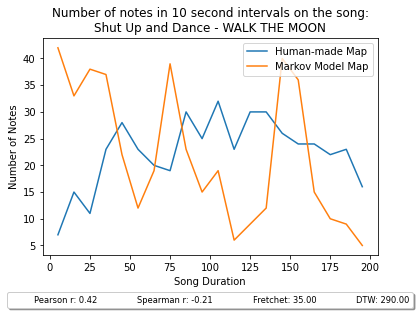

Pearson_r 0.2541035902079394
Spearman_r -0.11758075203182794
Curve length measure: 1.7310865370190276
Fretchet measure: 27.0
Dynamic time warping measure: 340.17878828622366


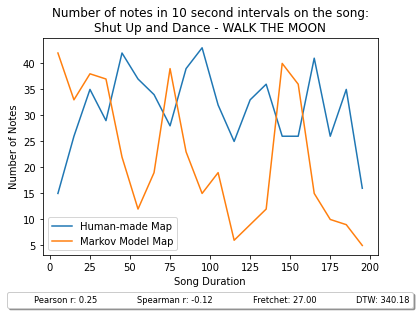

Removed 16 onset times for being within 0.1s of the next note
Pearson_r 0.6179836410667294
Spearman_r 0.3244047425743117
Curve length measure: 1.550547085585321
Fretchet measure: 18.0
Dynamic time warping measure: 121.0


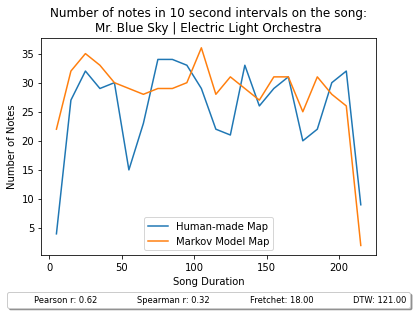

Removed 40 onset times for being within 0.1s of the next note
Pearson_r 0.17004015845041853
Spearman_r -0.10613972625516842
Curve length measure: 1.5171159908447998
Fretchet measure: 21.540659228538015
Dynamic time warping measure: 220.82256223398434


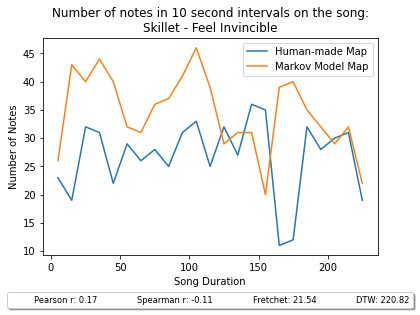

Removed 2 onset times for being within 0.1s of the next note
Pearson_r 0.7029407735411485
Spearman_r 0.6457399904693353
Curve length measure: 2.0902178032587595
Fretchet measure: 17.0
Dynamic time warping measure: 119.0


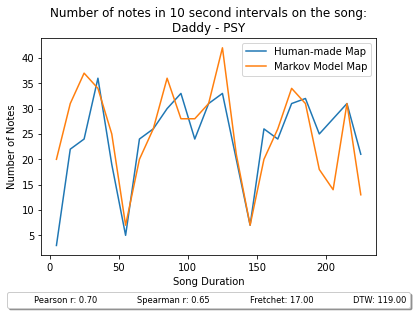

Removed 23 onset times for being within 0.1s of the next note
Pearson_r 0.7762455563200825
Spearman_r 0.7101927477432657
Curve length measure: 1.4234026328652096
Fretchet measure: 12.0
Dynamic time warping measure: 122.0


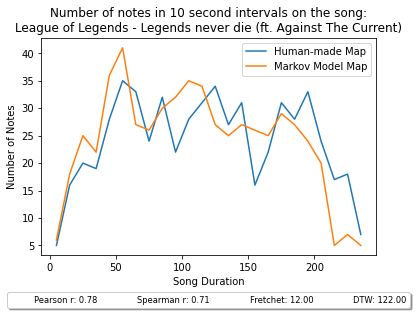

Pearson_r 0.8039043408596905
Spearman_r 0.6441865711684321
Curve length measure: 1.7610170201620534
Fretchet measure: 21.470910553583888
Dynamic time warping measure: 183.0


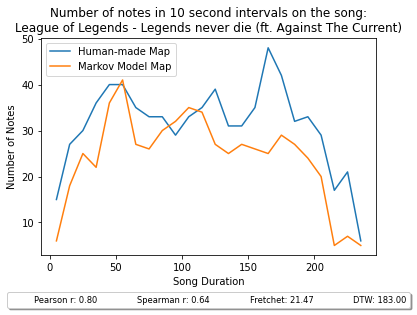

Removed 20 onset times for being within 0.1s of the next note
Pearson_r 0.3571977447978918
Spearman_r 0.3841367380670851
Curve length measure: 1.744256594164841
Fretchet measure: 26.92582403567252
Dynamic time warping measure: 325.65166307425926


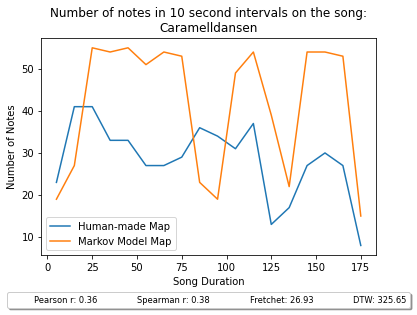

Removed 19 onset times for being within 0.1s of the next note
Pearson_r 0.8669501879060127
Spearman_r 0.8139711465451784
Curve length measure: 1.217229755891565
Fretchet measure: 16.0
Dynamic time warping measure: 161.0


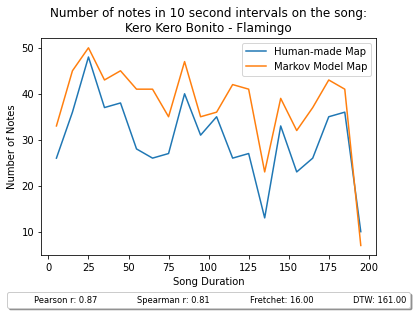

Removed 23 onset times for being within 0.1s of the next note
Pearson_r 0.11536411243528463
Spearman_r 0.09114408159153956
Curve length measure: 1.4989546594962282
Fretchet measure: 16.0
Dynamic time warping measure: 218.0


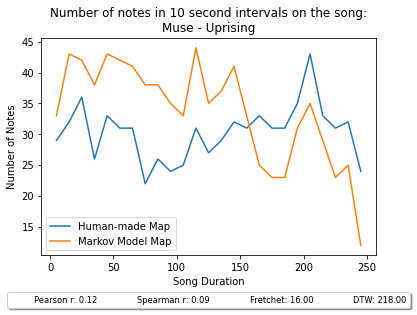

Removed 8 onset times for being within 0.1s of the next note
Pearson_r 0.804586516525398
Spearman_r 0.8480941224886818
Curve length measure: 1.0163885229175305
Fretchet measure: 18.867962264113206
Dynamic time warping measure: 89.0


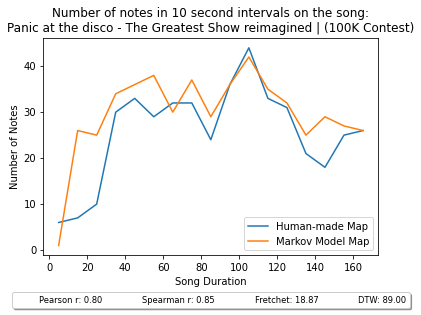

0.5349964781769467


In [174]:
average_r = compare_markov_model(maps_df, max_comparisons=100, plot=True)
print(average_r)

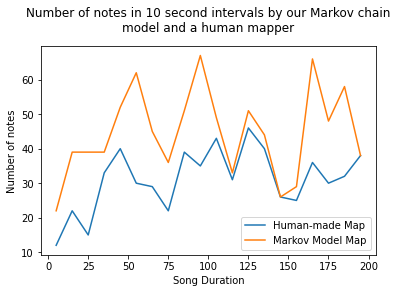

In [23]:
title = "Number of notes in 10 second intervals by our Markov chain model and a human mapper"
plt.subplots_adjust(top=0.85)
plt.title('\n'.join(wrap(title, 60)), y = 1.04)
xvals = [5 + 10*i for i in range(len(counts[0]))]
plt.plot(xvals, counts[0], label="Human-made Map")
plt.plot(xvals, generated_count, label="Markov Model Map")
plt.xlabel("Song Duration")
plt.ylabel("Number of notes")

plt.legend(loc='best')
plt.show()
# plt.savefig('comparison_song_1.png')

In [10]:
r, p = stats.pearsonr(counts[0], generated_count)
print("r:{}\np:{}".format(r, p))

r:0.5656315446326062
p:0.009340972171424341


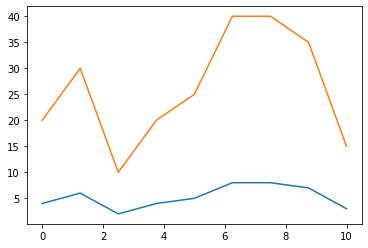

r:1.0
p:0.0


In [13]:
x = np.linspace(0,10,9)        
y1 = np.random.randint(0,10,9)
y2 = [y * 5 for y in y1]
plt.plot(x, y1, label="y1")
plt.plot(x, y2, label="y2")
plt.show()
r, p = stats.pearsonr(y1, y2)
print("r:{}\np:{}".format(r, p))

In [30]:
# Test our model
song_file_name = "(706a)_Redo_(TV_Size)_ReZero_Opening_-_Konomi_Suzuki"
# (7067)_Sorairo_Days_(TV_Size)_Gurren_Lagann_Opening_-_Shoko_Nakagawa

with ZipFile('../Data_Gather_Filter_Download/Zip_Songs_Data/{}.zip'.format(song_file_name)) as folder:
    folder.extract('song.egg')
    get_map_from_song('song.egg', markov_chain, start_time=0, bpm=190)
    os.remove('song.egg')

Removed 12 onset times for being within 0.1s of the next note
Removed 0 onset times for being before the specified start time
Creating output file at Generated_Maps/Expert.dat
c:\Users\Hayde\Documents\UofT Engineering\Fourth Year\Second Semester\APS360\Project\Evaluate_Models


FileNotFoundError: [Errno 2] No such file or directory: 'Generated_Maps/Expert.dat'